In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_colwidth = 999
pd.options.display.max_rows = 999

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer

from sklearn.metrics import roc_auc_score
from sklearn.metrics import mutual_info_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
water_data = pd.read_csv('data/water_potability.csv')

In [3]:
water_data.columns = water_data.columns.str.lower().str.replace(' ', '_')

In [4]:
water_data.head()

,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [5]:
water_data.describe().T

,count,mean,std,min,25%,50%,75%,max
ph,2785.0,7.080795,1.594320,0.000000,6.093092,7.036752,8.062066,14.000000
hardness,3276.0,196.369496,32.879761,47.432000,176.850538,196.967627,216.667456,323.124000
solids,3276.0,22014.092526,8768.570828,320.942611,15666.690297,20927.833607,27332.762127,61227.196008
chloramines,3276.0,7.122277,1.583085,0.352000,6.127421,7.130299,8.114887,13.127000
sulfate,2495.0,333.775777,41.416840,129.000000,307.699498,333.073546,359.950170,481.030642
conductivity,3276.0,426.205111,80.824064,181.483754,365.734414,421.884968,481.792304,753.342620
organic_carbon,3276.0,14.284970,3.308162,2.200000,12.065801,14.218338,16.557652,28.300000
trihalomethanes,3114.0,66.396293,16.175008,0.738000,55.844536,66.622485,77.337473,124.000000
turbidity,3276.0,3.966786,0.780382,1.450000,3.439711,3.955028,4.500320,6.739000
potability,3276.0,0.390110,0.487849,0.000000,0.000000,0.000000,1.000000,1.000000


Column description:

1. ph: pH of 1. water (0 to 14).
2. Hardness: Capacity of water to precipitate soap in mg/L.
3. Solids: Total dissolved solids in ppm.
4. Chloramines: Amount of Chloramines in ppm.
5. Sulfate: Amount of Sulfates dissolved in mg/L.
6. Conductivity: Electrical conductivity of water in μS/cm.
7. Organic_carbon: Amount of organic carbon in ppm.
8. Trihalomethanes: Amount of Trihalomethanes in μg/L.
9. Turbidity: Measure of light emiting property of water in NTU.
10. Potability: Indicates if water is safe for human consumption. Potable -1 and Not potable -0

In [6]:
water_data.isnull().sum()

ph                 491
hardness             0
solids               0
chloramines          0
sulfate            781
conductivity         0
organic_carbon       0
trihalomethanes    162
turbidity            0
potability           0
dtype: int64

In [7]:
water_data = water_data.dropna()

In [8]:
df_full_train, df_test = train_test_split(water_data, test_size=0.2, random_state=1)

df_train, df_val  = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(df_train), len(df_val), len(df_test)

(1206, 402, 403)

In [9]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['potability'].values
y_val = df_val['potability'].values
y_test = df_test['potability'].values

del df_train['potability']
del df_val['potability']
del df_test['potability']

In [10]:
df_full_train.nunique()

ph                 1608
hardness           1608
solids             1608
chloramines        1608
sulfate            1608
conductivity       1608
organic_carbon     1608
trihalomethanes    1608
turbidity          1608
potability            2
dtype: int64

In [11]:
correlations = df_train.corr()
correlations

,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity
ph,1.000000,0.124217,-0.076731,-0.034642,0.000089,0.011680,0.019419,0.036286,-0.006090
hardness,0.124217,1.000000,-0.063892,-0.045881,-0.111409,-0.009152,0.000367,-0.026256,-0.015567
solids,-0.076731,-0.063892,1.000000,-0.061134,-0.152874,-0.012225,-0.018185,0.012462,0.016329
chloramines,-0.034642,-0.045881,-0.061134,1.000000,0.029642,-0.046040,-0.034337,0.013267,0.045010
sulfate,0.000089,-0.111409,-0.152874,0.029642,1.000000,-0.031510,0.026061,-0.026431,-0.024705
conductivity,0.011680,-0.009152,-0.012225,-0.046040,-0.031510,1.000000,0.000761,0.017522,0.012760
organic_carbon,0.019419,0.000367,-0.018185,-0.034337,0.026061,0.000761,1.000000,-0.009685,-0.012514
trihalomethanes,0.036286,-0.026256,0.012462,0.013267,-0.026431,0.017522,-0.009685,1.000000,-0.046867
turbidity,-0.006090,-0.015567,0.016329,0.045010,-0.024705,0.012760,-0.012514,-0.046867,1.000000


<AxesSubplot:>

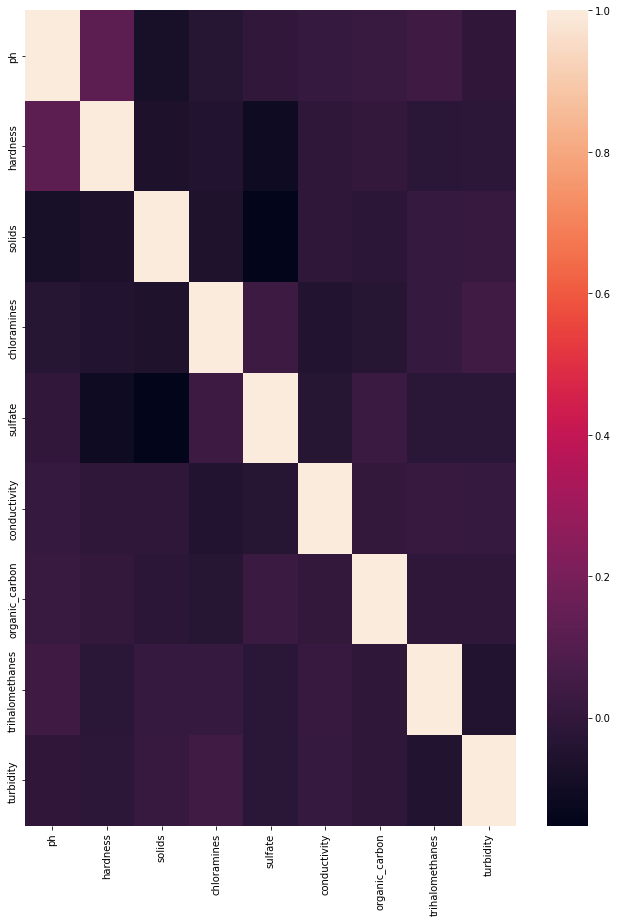

In [12]:
plt.figure(figsize=(11, 15))
sns.heatmap(correlations)

We see there is not much correlation between the features, the features with the most correlation are PH and Hardness, which knowing a little bit about water chemistry is not suprising but it is still a correlation below 0.1

In [13]:
def mutual_info_potability_score(series):
    return mutual_info_score(series, df_full_train['potability'])
    

mi = df_full_train[df_train.columns].apply(mutual_info_potability_score)
mi.sort_values(ascending=False)

ph                 0.677245
hardness           0.677245
solids             0.677245
chloramines        0.677245
sulfate            0.677245
conductivity       0.677245
organic_carbon     0.677245
trihalomethanes    0.677245
turbidity          0.677245
dtype: float64

### Parameter selection

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300, 750, 1000], 
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False],
    'criterion':['entropy', 'gini']
}

rfcgrid = GridSearchCV(
    RandomForestClassifier(random_state=101),
    param_grid,
    verbose=100,
    cv=10,
    n_jobs=-2
)

rfcgrid.fit(df_train, y_train)

In [ ]:
rfcgrid.best_params_

In [14]:
def train(df, y_train):
    dicts = df.to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = RandomForestClassifier(
        bootstrap=True,
        criterion='entropy',
        max_features='sqrt',
        n_estimators=100
    )
    model.fit(X_train, y_train)
    
    return dv, model

In [15]:
dv, model = train(df_train, y_train)

In [16]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict(X)
    
    return y_pred

In [17]:
y_pred = predict(df_val,dv, model)
roc_auc_score(y_val, y_pred)

0.6247237748602625

In [18]:
original_accuracy = (y_val == y_pred).mean()
original_accuracy

0.6666666666666666

In [19]:
def model_accuracy(feature_to_remove):
    print(feature_to_remove)
    print()
    sub_features = np.array([x for x in df_train.columns if x != feature_to_remove])
    train_dicts = df_train[sub_features].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)
    val_dicts = df_val[sub_features].to_dict(orient='records')
    X_val = dv.transform(val_dicts)
    model = LogisticRegression(solver='liblinear', C=1.0, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    diff = original_accuracy - (y_val == y_pred).mean()
    print(round(original_accuracy, 4), round((y_val == y_pred).mean(), 4), round(diff, 4))
    print()

In [20]:
model_accuracy('ph')
model_accuracy('hardness')
model_accuracy('solids')
model_accuracy('chloramines')
model_accuracy('sulfate')
model_accuracy('conductivity')
model_accuracy('organic_carbon')
model_accuracy('trihalomethanes')
model_accuracy('turbidity')

ph

0.6667 0.6095 0.0572

hardness

0.6667 0.602 0.0647

solids

0.6667 0.6095 0.0572

chloramines

0.6667 0.6144 0.0522

sulfate

0.6667 0.607 0.0597

conductivity

0.6667 0.6169 0.0498

organic_carbon

0.6667 0.6144 0.0522

trihalomethanes

0.6667 0.6119 0.0547

turbidity

0.6667 0.6119 0.0547



In [21]:
features = ['trihalomethanes', 'turbidity', 'sulfate', 'hardness', 'ph', 'solids' ]

In [22]:
dv, model = train(df_train[features], y_train)

In [23]:
y_pred = predict(df_val[features],dv, model)
roc_auc_score(y_val, y_pred)

0.589535941765241

In [24]:
accuracy = (y_val == y_pred).mean()
accuracy

0.6293532338308457